In [1]:
# Dataset

In [2]:
import os, zipfile, requests

In [3]:
if not os.path.exists("bank-full.csv"):
    print("Downloading bank-full.csv file...")
    response = requests.get("https://archive.ics.uci.edu/static/public/222/bank+marketing.zip")
    with open("bank+marketing.zip", 'wb') as zip_file:
        zip_file.write(response.content)
    with zipfile.ZipFile("bank+marketing.zip", "r") as zip_file:
        zip_file.extractall()
    with zipfile.ZipFile("bank.zip", "r") as zip_file:
        zip_file.extractall()
    for file in [
        "bank+marketing.zip",
        "bank.zip",
        "bank-additional.zip",
        "bank.csv",
        "bank-names.txt",
    ]:
        os.remove(file)
    print("bank-full.csv was downloaded successfully.")
    
else:
    print("bank-full.csv is already downloaded.")

bank-full.csv is already downloaded.


In [4]:
# Dataset preparation

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv("bank-full.csv", delimiter=";")
df = df[[
    "age",
    "job",
    "marital",
    "education",
    "balance",
    "housing",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "poutcome",
    "y"
]]
df.y = (df.y == 'yes').astype(int)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [7]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [8]:
# Question 1

In [9]:
from sklearn.metrics import roc_auc_score

In [10]:
features = ["balance", "day", "duration", "previous"]
for feature in features:
    score = roc_auc_score(y_train, df_train[feature])
    if score < 0.5:
        score = roc_auc_score(y_train, -df_train[feature])
    print(feature, ":\t" , score)

balance :	 0.5888313805382317
day :	 0.525957882383908
duration :	 0.8147002759670778
previous :	 0.5985653242764153


In [11]:
# Question 2

In [12]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [13]:
def train(df_train, y_train):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [14]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [15]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)
round(roc_auc_score(y_val, y_pred).item(), 4)

0.9003

In [16]:
# Question 3

In [17]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

In [18]:
scores = []

thresholds = np.linspace(0, 1, 101)

for threshold in thresholds:
    precision = precision_score(y_val, y_pred > threshold, zero_division=np.nan)
    recall = recall_score(y_val, y_pred > threshold, zero_division=np.nan)
    scores.append((threshold, precision, recall))


columns = ["threshold", "precision", "recall"]
df_scores = pd.DataFrame(scores, columns=columns)

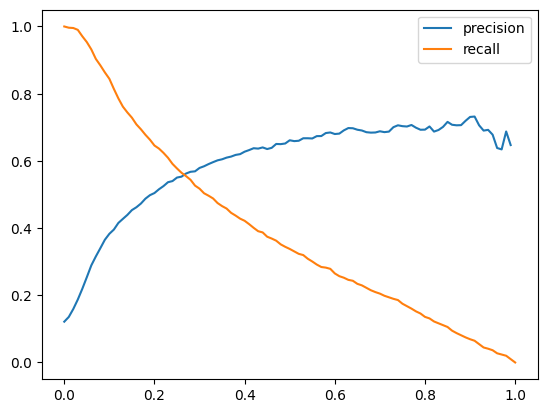

In [19]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')
plt.legend()

In [20]:
df_scores[(df_scores.threshold == 0.26) | (df_scores.threshold == 0.27)]

,threshold,precision,recall
26,0.26,0.553078,0.564663
27,0.27,0.562327,0.554645


In [21]:
# Question 4

In [22]:
from sklearn.metrics import f1_score

In [23]:
f1_scores = []

for threshold in thresholds:
    f1 = f1_score(y_val, y_pred > threshold, zero_division=np.nan)
    f1_scores.append(f1)

df_scores["f1"] = f1_scores

In [24]:
df_scores.loc[df_scores['f1'].idxmax()]

threshold    0.230000
precision    0.536488
recall       0.609290
f1           0.570576
Name: 23, dtype: float64

In [25]:
# Question 5

In [26]:
from sklearn.model_selection import KFold

In [27]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    del df_train['y']
    del df_val['y']

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

round(np.std(scores).item(), 3)

0.006

In [28]:
# Question 6

In [29]:
def train(df_train, y_train, C):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [30]:
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.y.values
        y_val = df_val.y.values
    
        del df_train['y']
        del df_val['y']
    
        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(C, ":\t", round(np.mean(scores), 3), " +- ",  round(np.std(scores), 3))

1e-06 :	 0.701  +-  0.009
0.001 :	 0.861  +-  0.007
1 :	 0.906  +-  0.006
